# Time series decomposition

### 1. Import the libraries and authenticate

In [54]:
import pandas as pd
import nasdaqdatalink
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt

In [55]:
nasdaqdatalink.ApiConfig.api_key = 'hbwVh8xyxkjEKo8D1P8c'

### 2. Download the monthly US unemployment rate from the years 2010 to 2019.

In [56]:
df = (
    nasdaqdatalink.get(
        dataset='FRED/UNRATENSA',
        start_date='2010-01-01',
        end_date='2019-12-31'
    )
    .rename(columns={'Value': 'unemp_rate'})
)

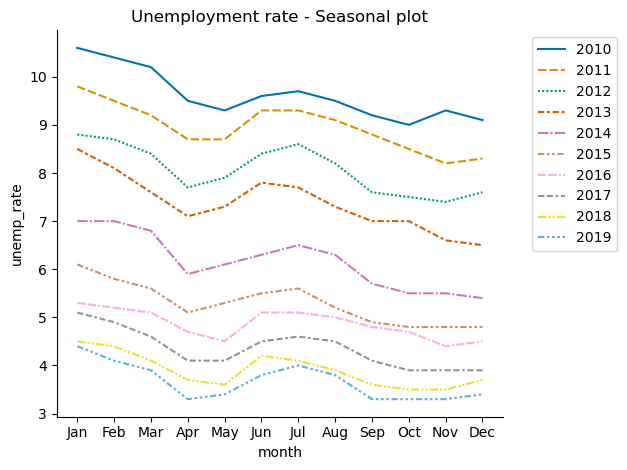

In [57]:
# quick look at the plot
temp_df = df.copy()

temp_df['year'] = temp_df.index.year
temp_df['month'] = temp_df.index.strftime('%b')

sns.lineplot(
    data=temp_df,
    x='month',
    y='unemp_rate',
    hue='year',
    style='year',
    legend='full',
    palette='colorblind'
)

plt.title('Unemployment rate - Seasonal plot')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2)

sns.despine()   # remove top and right spines from plot
plt.tight_layout()

### 3. Add rolling mean and standard deviation.

<Axes: title={'center': 'unemployment rate'}, xlabel='Date'>

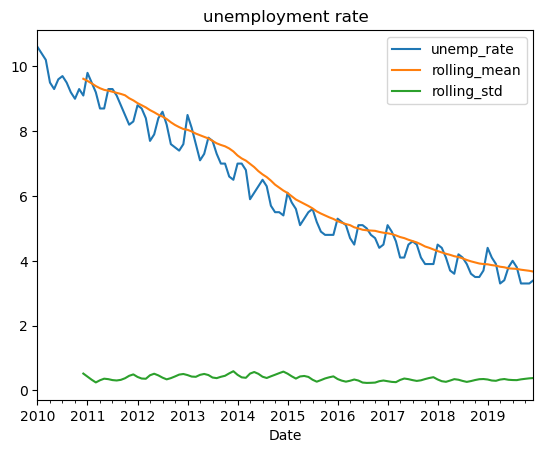

In [58]:
WINDOW_SIZE = 12
df['rolling_mean'] = df['unemp_rate'].rolling(WINDOW_SIZE).mean()
df['rolling_std'] = df['unemp_rate'].rolling(WINDOW_SIZE).std()
df.plot(title='unemployment rate')

### 4. Carry out the seasonal decompostiion using the additive model.

Text(0.5, 0.98, 'Addivie Decomposition')

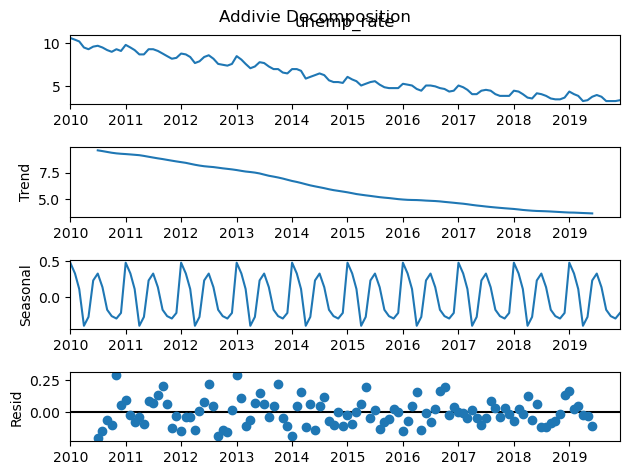

In [59]:
decomposition_results = seasonal_decompose(df['unemp_rate'], model='additive')

(
    decomposition_results
    .plot()
    .suptitle('Addivie Decomposition')
)

Text(0.5, 0.98, 'STL Decomposition')

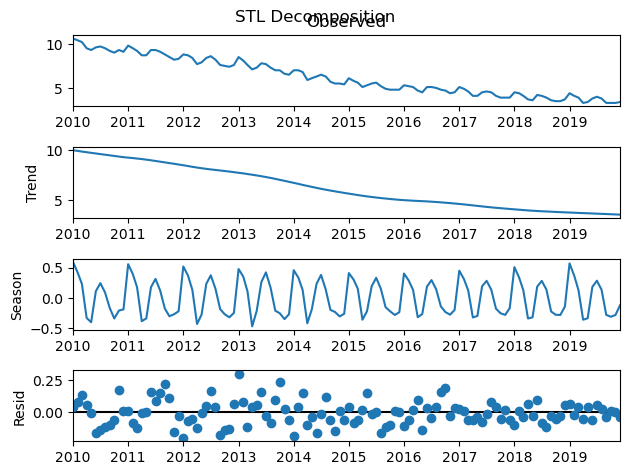

In [60]:
from statsmodels.tsa.seasonal import STL
stl_decomposition = STL(df[['unemp_rate']]).fit()
stl_decomposition.plot().suptitle('STL Decomposition')

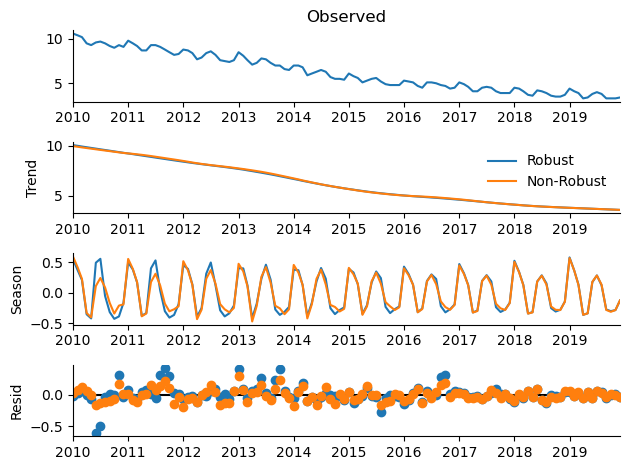

In [61]:
# Compare the decomposition with and without robust setting

def add_second_stl_to_plot(fig, fitted_stl, labels):
    """
    A helper function adding the 3 components from the second STL fit to the first STL plot.
    """

    axs = fig.get_axes()
    comps = ['trend', 'seasonal', 'resid']
    for ax, comp in zip(axs[1:], comps):
        series = getattr(fitted_stl, comp)
        if comp == 'resid':
            ax.plot(series, marker='o', linestyle='none')
        else:
            ax.plot(series)
            if comp == 'trend':
                ax.legend(labels, frameon=False)

stl_robust = STL(df[['unemp_rate']], robust=True).fit()
stl_non_robust = STL(df[['unemp_rate']], robust=False).fit()
fig = stl_robust.plot()
add_second_stl_to_plot(fig, stl_non_robust, ['Robust', 'Non-Robust'])

sns.despine()
plt.tight_layout()


# Testing for stationarity in time series

### 1. Import the libraries

In [62]:
import pandas as pd
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller, kpss

### 2. Define a function for running the ADF test

In [63]:
def adf_test(x):
    indices = ['Test Statistic', 'p-value', '# of Lags Used', '# of Observations Used']

    adf_test = adfuller(x, autolag='AIC')
    results = pd.Series(adf_test[0:4], index=indices)

    for key, value in adf_test[4].items():
        results[f'Critical Value ({key})'] = value
    
    return results

In [64]:
adf_test(df['unemp_rate'])

Test Statistic             -2.053411
p-value                     0.263656
# of Lags Used             12.000000
# of Observations Used    107.000000
Critical Value (1%)        -3.492996
Critical Value (5%)        -2.888955
Critical Value (10%)       -2.581393
dtype: float64

### 3. Define a function for running the KPSS test

In [65]:
def kpss_test(x, h0_type='c'):
    indices = ['Test Statistic', 'p-value', '# of Lags']
    kpss_test = kpss(x, regression=h0_type)
    results = pd.Series(kpss_test[0:3], index=indices)

    for key, value in kpss_test[3].items():
        results[f'Critical Value ({key})'] = value
    
    return results

In [66]:
kpss_test(df['unemp_rate'])

/Users/woojin/miniforge3/envs/finance/lib/python3.11/site-packages/statsmodels/tsa/stattools.py:2018: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warnings.warn(


Test Statistic           1.799224
p-value                  0.010000
# of Lags                6.000000
Critical Value (10%)     0.347000
Critical Value (5%)      0.463000
Critical Value (2.5%)    0.574000
Critical Value (1%)      0.739000
dtype: float64

### 4. Generate the ACF/PACF plots

/Users/woojin/miniforge3/envs/finance/lib/python3.11/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


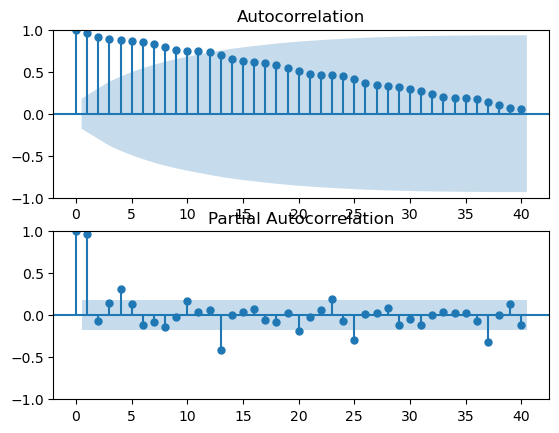

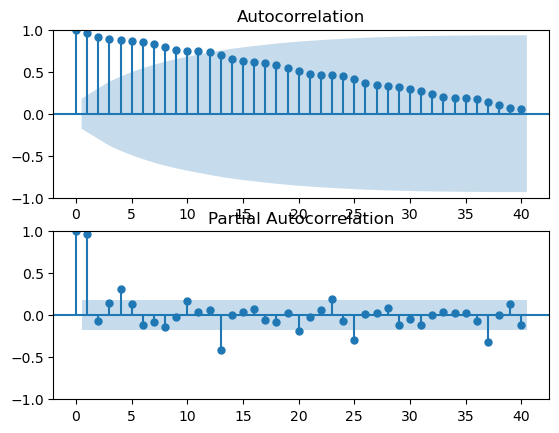

In [67]:
N_LAGS = 40
SIGNIFICANCE_LEVEL = 0.05
fig, ax = plt.subplots(2, 1)
plot_acf(df['unemp_rate'], ax=ax[0], lags=N_LAGS, alpha=SIGNIFICANCE_LEVEL)
plot_pacf(df['unemp_rate'], ax=ax[1], lags=N_LAGS, alpha=SIGNIFICANCE_LEVEL)

In [68]:
from arch.unitroot import ADF
adf = ADF(df['unemp_rate'])
print(adf.summary().as_text())

   Augmented Dickey-Fuller Results   
Test Statistic                 -2.053
P-value                         0.264
Lags                               12
-------------------------------------

Trend: Constant
Critical Values: -3.49 (1%), -2.89 (5%), -2.58 (10%)
Null Hypothesis: The process contains a unit root.
Alternative Hypothesis: The process is weakly stationary.


In [69]:
from arch.unitroot import ZivotAndrews
za = ZivotAndrews(df['unemp_rate'])
print(za.summary().as_text())

        Zivot-Andrews Results        
Test Statistic                 -2.551
P-value                         0.982
Lags                               12
-------------------------------------

Trend: Constant
Critical Values: -5.28 (1%), -4.81 (5%), -4.57 (10%)
Null Hypothesis: The process contains a unit root with a single structural break.
Alternative Hypothesis: The process is trend and break stationary.


# Correcting for stationary in time series

### 1. Import the libraries and authenticate and update the inflation data.

In [70]:
import pandas as pd
import numpy as np
import nasdaqdatalink
import cpi
from datetime import date
from chapter_6_utils import test_autocorrelation
nasdaqdatalink.ApiConfig.api_key = 'hbwVh8xyxkjEKo8D1P8c'

### 2. Download the prices of gold and resample to monthly values.

In [71]:
df = (
    nasdaqdatalink.get(dataset='WGC/GOLD_MONAVG_USD', start_date='2000-01-01', end_date='2010-12-31')
    .rename(columns={'Value': 'price'})
    .resample('M')
    .last()
)

ADF test statistics: 2.41 (p-val: 1.00)
KPSS test statistics: 1.84 (p-val: 0.01)


/Users/woojin/miniforge3/envs/finance/lib/python3.11/site-packages/statsmodels/tsa/stattools.py:2018: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warnings.warn(
/Users/woojin/miniforge3/envs/finance/lib/python3.11/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


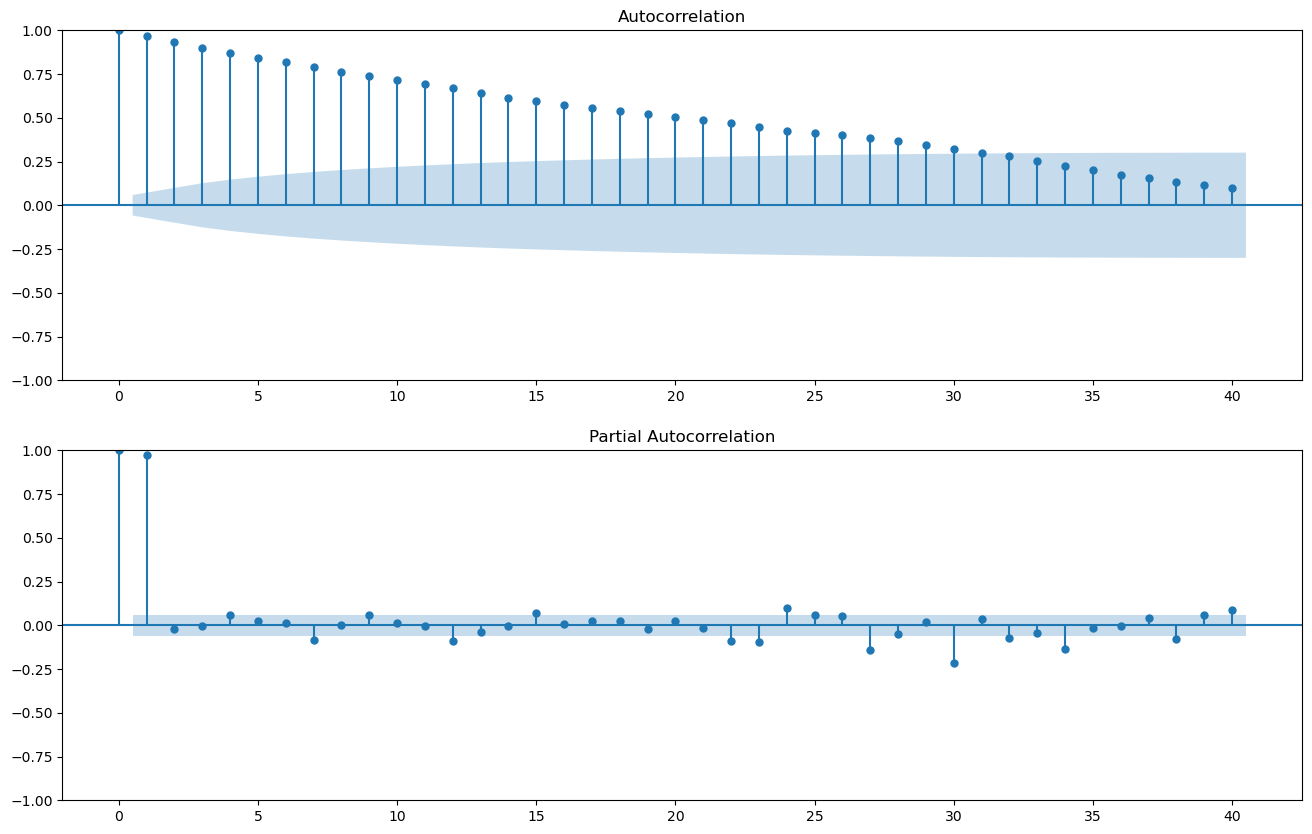

In [72]:
# check if the series is stationary - it is not
fig = test_autocorrelation(df['price'])

### 3. Deflate the gold prices (to the 2010-12-31 USD value) and plot the reulsts.

/Users/woojin/miniforge3/envs/finance/lib/python3.11/site-packages/cpi/__init__.py:109: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these will be considered non-comparable. Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  if year_or_month == to:


<Axes: title={'center': 'Gold Price (deflated)'}, xlabel='Date'>

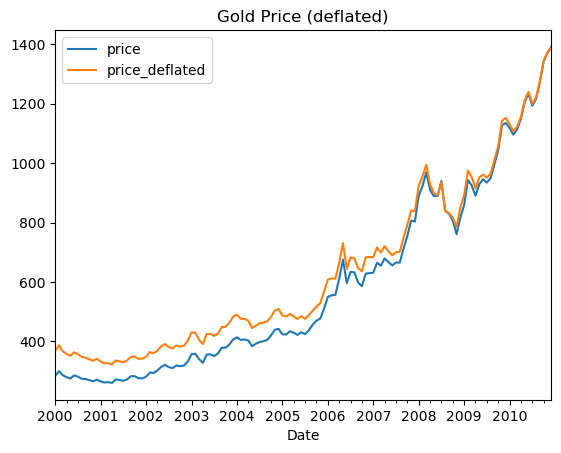

In [73]:
DEFL_DATE = date(2010, 12, 31)
df['df_index'] = pd.to_datetime(df.index)
df['price_deflated'] = df.apply(
    lambda x: cpi.inflate(x['price'], x['df_index'], DEFL_DATE),
    axis=1
)
(
    df.loc[:, ['price', 'price_deflated']]
    .plot(title='Gold Price (deflated)')
)

### 4. Apply the natural logarithm to the deflated series and plot it together with the rolling metrics.

array([<Axes: xlabel='Date'>, <Axes: xlabel='Date'>,
       <Axes: xlabel='Date'>], dtype=object)

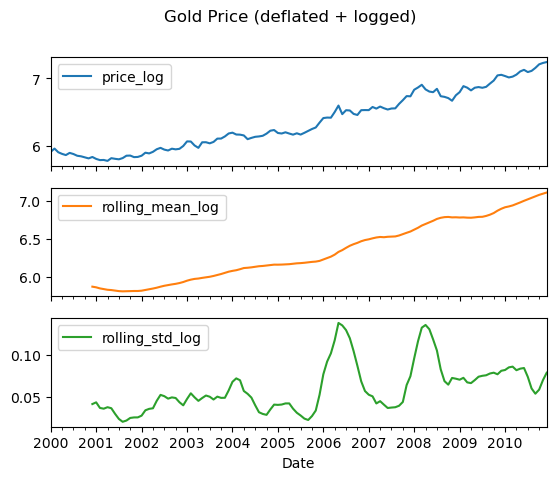

In [74]:
WINDOW = 12
selected_columns = ['price_log', 'rolling_mean_log', 'rolling_std_log']
df['price_log'] = np.log(df.price_deflated)
df['rolling_mean_log'] = df.price_log.rolling(WINDOW).mean()
df['rolling_std_log'] = df.price_log.rolling(WINDOW).std()
(
    df[selected_columns]
    .plot(title='Gold Price (deflated + logged)', subplots=True)
)

### 5. Use the test_autocorrelation to investigate if the series became stationary.

ADF test statistics: 1.04 (p-val: 0.99)
KPSS test statistics: 1.93 (p-val: 0.01)


/Users/woojin/miniforge3/envs/finance/lib/python3.11/site-packages/statsmodels/tsa/stattools.py:2018: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warnings.warn(
/Users/woojin/miniforge3/envs/finance/lib/python3.11/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


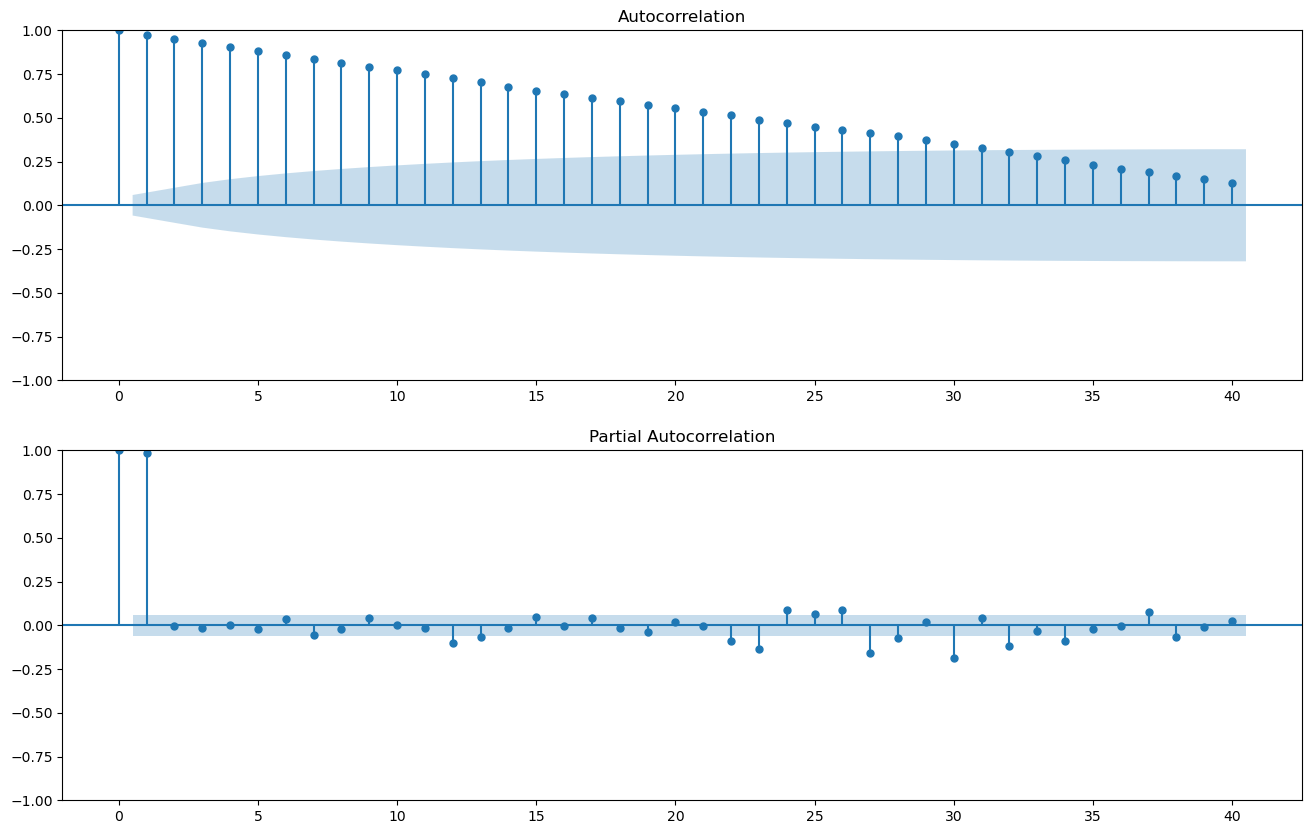

In [75]:
fig = test_autocorrelation(df['price_log'])

### 6. Apply differencing to the series and plot the results.

<Axes: title={'center': 'Gold Price (deflated + logged + diff)'}, xlabel='Date'>

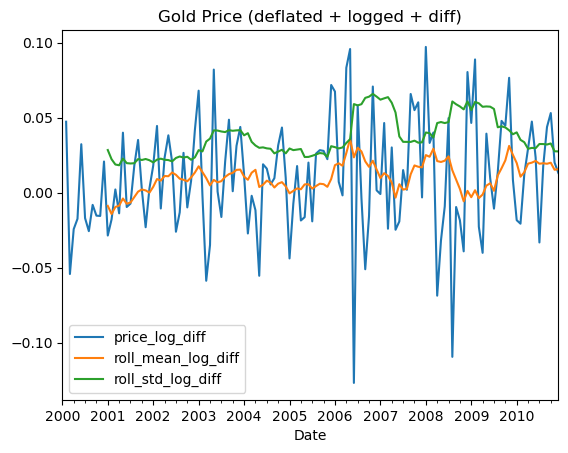

In [76]:
selected_columns = ['price_log_diff', 'roll_mean_log_diff', 'roll_std_log_diff']

df['price_log_diff'] = df.price_log.diff()
df['roll_mean_log_diff'] = df.price_log_diff.rolling(WINDOW).mean()
df['roll_std_log_diff'] = df.price_log_diff.rolling(WINDOW).std()

df[selected_columns].plot(title='Gold Price (deflated + logged + diff)')

### 7. Test if the series became stationary.

ADF test statistics: -10.87 (p-val: 0.00)
KPSS test statistics: 0.30 (p-val: 0.10)


/Users/woojin/miniforge3/envs/finance/lib/python3.11/site-packages/statsmodels/tsa/stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(
/Users/woojin/miniforge3/envs/finance/lib/python3.11/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


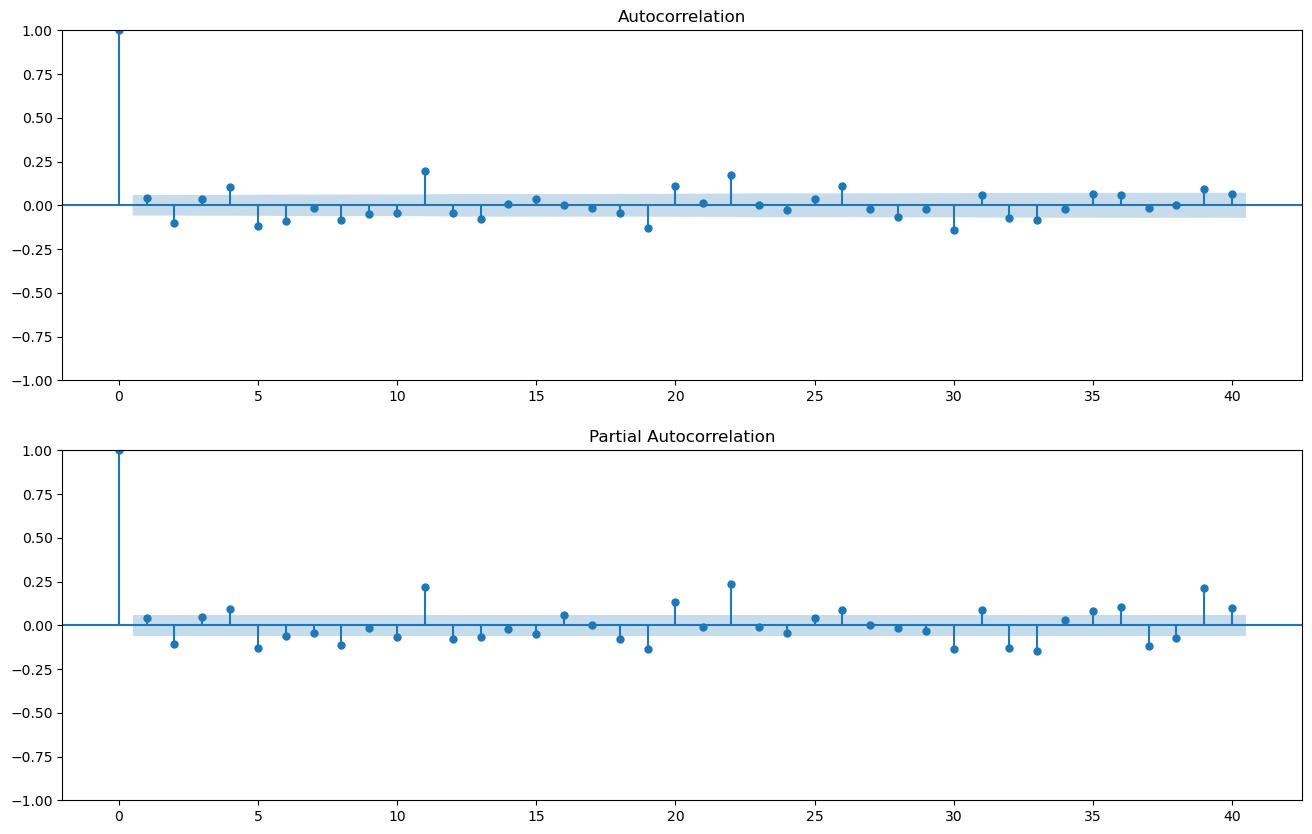

In [77]:
fig = test_autocorrelation(df['price_log_diff'].dropna())

In [78]:
# we can employ the following tests to investigate stationarity: ADF, KPSS, and Phillips-Perron.
from pmdarima.arima import ndiffs, nsdiffs

print(f"Suggested # of differeces (ADF): {ndiffs(df['price'], test='adf')}")
print(f"Suggested # of differeces (KPSS): {ndiffs(df['price'], test='kpss')}")
print(f"Suggested # of differeces (PP): {ndiffs(df['price'], test='pp')}")

Suggested # of differeces (ADF): 1
Suggested # of differeces (KPSS): 2
Suggested # of differeces (PP): 1


In [79]:
print(f'Suggested # of differences (OSCB): {nsdiffs(df["price"], m=12, test="ocsb")}')
print(f'Suggested # of differences (CH): {nsdiffs(df["price"], m=12, test="ch")}')

Suggested # of differences (OSCB): 0
Suggested # of differences (CH): 0


# Modeling time series iwth exponential smoothing methods

### 1. Getting ready

In [92]:
import pandas as pd
import nasdaqdatalink

nasdaqdatalink.ApiConfig.api_key = 'hbwVh8xyxkjEKo8D1P8c'

In [93]:
df = (
    nasdaqdatalink.get(dataset='FRED/UNRATENSA', start_date='2010-01-01', end_date='2019-12-31')
)
df.head()

,Value
Date,
2010-01-01,10.6
2010-02-01,10.4
2010-03-01,10.2
2010-04-01,9.5
2010-05-01,9.3


### 2. Import the libraries

In [94]:
import pandas as pd
from datetime import date
from statsmodels.tsa.holtwinters import (ExponentialSmoothing, SimpleExpSmoothing, Holt)

In [95]:
TEST_LENGTH = 12
df.index.freq = 'MS'
df_train = df.iloc[:-TEST_LENGTH]
df_test = df.iloc[-TEST_LENGTH:]

### 3. Fit two SES models and calculate the forecasts.

In [96]:
ses_1 = SimpleExpSmoothing(df_train).fit(smoothing_level=0.5)
ses_forecast_1 = ses_1.forecast(TEST_LENGTH)

ses_2 = SimpleExpSmoothing(df_train).fit()
ses_forecast_2 = ses_2.forecast(TEST_LENGTH)

ses_1.params_formatted

,name,param,optimized
smoothing_level,alpha,0.500000,False
initial_level,l.0,10.358112,True


In [97]:
ses_1.summary()

Dep. Variable:,Value,No. Observations:,108
Model:,SimpleExpSmoothing,SSE,15.032
Optimized:,True,AIC,-208.973
Trend:,None,BIC,-203.609
Seasonal:,None,AICC,-208.584
Seasonal Periods:,None,Date:,"Sun, 09 Jul 2023"
Box-Cox:,False,Time:,22:57:44
Box-Cox Coeff.:,None,,
,coeff,code,optimized
smoothing_level,0.5000000,alpha,False
initial_level,10.358112,l.0,True


### 4. Combine the forecasts with the fitted values and plot them.

/var/folders/dt/q9f0jq252ld5kmwg8rqf4pgw0000gn/T/ipykernel_4861/798982602.py:2: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ses_df["ses_1"] = ses_1.fittedvalues.append(ses_forecast_1)
/var/folders/dt/q9f0jq252ld5kmwg8rqf4pgw0000gn/T/ipykernel_4861/798982602.py:3: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ses_df["ses_2"] = ses_2.fittedvalues.append(ses_forecast_2)


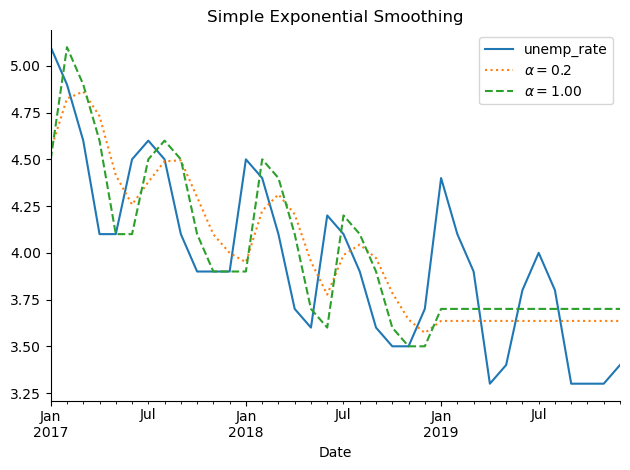

In [98]:
ses_df = df.copy()
ses_df["ses_1"] = ses_1.fittedvalues.append(ses_forecast_1)
ses_df["ses_2"] = ses_2.fittedvalues.append(ses_forecast_2)

opt_alpha = ses_2.model.params["smoothing_level"]

fig, ax = plt.subplots()
ses_df["2017":].plot(style=["-",":","--"], ax=ax,
                     title="Simple Exponential Smoothing")
labels = [
    "unemp_rate", 
    r"$\alpha=0.2$",
    r"$\alpha={0:.2f}$".format(opt_alpha), 
]
ax.legend(labels)

sns.despine()
plt.tight_layout()

### 5. Fit three variants of Holt’s linear trend models and calculate the forecasts.

In [99]:
# Holt's model with linear trend
hs_1 = Holt(df_train).fit()
hs_forecast_1 = hs_1.forecast(TEST_LENGTH)

# Holt's model with exponential trend
hs_2 = Holt(df_train, exponential=True).fit()
# equivalent to ExponentialSmoothing(df_train, trend="mul").fit()
hs_forecast_2 = hs_2.forecast(TEST_LENGTH)

# Holt's model with exponential trend and damping
hs_3 = Holt(df_train, exponential=False,
            damped_trend=True).fit()
hs_forecast_3 = hs_3.forecast(TEST_LENGTH)

In [100]:
hs_3.params_formatted

,name,param,optimized
smoothing_level,alpha,1.000000e+00,True
smoothing_trend,beta,1.396992e-15,True
initial_level,l.0,1.070994e+01,True
initial_trend,b.0,-1.102251e-01,True
damping_trend,phi,9.890185e-01,True


### 6. Plot the original series together with the model’s forecasts.

/var/folders/dt/q9f0jq252ld5kmwg8rqf4pgw0000gn/T/ipykernel_4861/1481000746.py:2: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  hs_df["hs_1"] = hs_1.fittedvalues.append(hs_forecast_1)
/var/folders/dt/q9f0jq252ld5kmwg8rqf4pgw0000gn/T/ipykernel_4861/1481000746.py:3: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  hs_df["hs_2"] = hs_2.fittedvalues.append(hs_forecast_2)
/var/folders/dt/q9f0jq252ld5kmwg8rqf4pgw0000gn/T/ipykernel_4861/1481000746.py:4: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  hs_df["hs_3"] = hs_3.fittedvalues.append(hs_forecast_3)


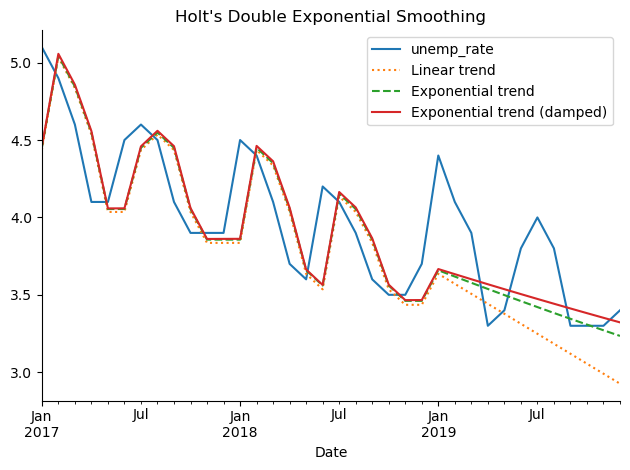

In [101]:
hs_df = df.copy()
hs_df["hs_1"] = hs_1.fittedvalues.append(hs_forecast_1)
hs_df["hs_2"] = hs_2.fittedvalues.append(hs_forecast_2)
hs_df["hs_3"] = hs_3.fittedvalues.append(hs_forecast_3)

fig, ax = plt.subplots()
hs_df["2017":].plot(style=["-",":","--"], ax=ax,
                    title="Holt's Double Exponential Smoothing")

labels = [
    "unemp_rate",
    "Linear trend",
    "Exponential trend",
    "Exponential trend (damped)"
]

ax.legend(labels)

sns.despine()
plt.tight_layout()

### 7. Fit two variants of Hold-Winters’ Triple Exponential Smoothing models and calculate the forecasts.

In [102]:
SEASONAL_PERIODS = 12

# Holt-Winters' model with exponential trend
hw_1 = ExponentialSmoothing(df_train, 
                            trend="mul",
                            seasonal="add",
                            seasonal_periods=SEASONAL_PERIODS).fit()
hw_forecast_1 = hw_1.forecast(TEST_LENGTH)

# Holt-Winters' model with exponential trend and damping
hw_2 = ExponentialSmoothing(df_train,
                            trend="mul",
                            seasonal="add",
                            seasonal_periods=SEASONAL_PERIODS,
                            damped_trend=True).fit()
hw_forecast_2 = hw_2.forecast(TEST_LENGTH)

In [103]:
hw_2.params_formatted

,name,param,optimized
smoothing_level,alpha,0.632942,True
smoothing_trend,beta,0.000000,True
smoothing_seasonal,gamma,0.000000,True
initial_level,l.0,8.210423,True
initial_trend,b.0,1.009639,True
damping_trend,phi,0.972787,True
initial_seasons.0,s.0,2.529609,True
initial_seasons.1,s.1,2.400610,True
initial_seasons.2,s.2,2.193658,True
initial_seasons.3,s.3,1.686383,True


### 8. Plot the original series together with the model's results.

/var/folders/dt/q9f0jq252ld5kmwg8rqf4pgw0000gn/T/ipykernel_4861/3451533869.py:2: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  hw_df["hw_1"] = hw_1.fittedvalues.append(hw_forecast_1)
/var/folders/dt/q9f0jq252ld5kmwg8rqf4pgw0000gn/T/ipykernel_4861/3451533869.py:3: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  hw_df["hw_2"] = hw_2.fittedvalues.append(hw_forecast_2)


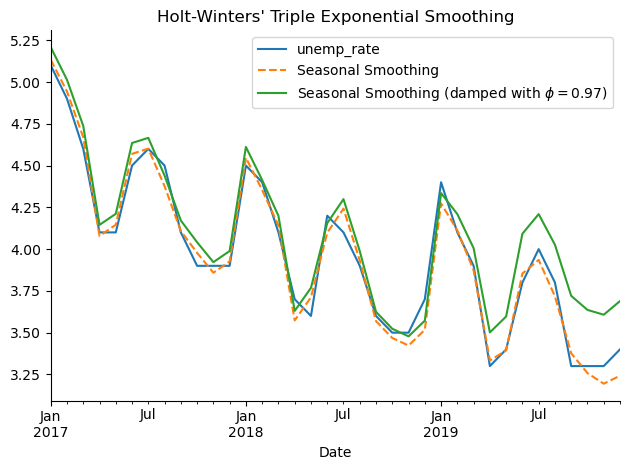

In [104]:
hw_df = df.copy()
hw_df["hw_1"] = hw_1.fittedvalues.append(hw_forecast_1)
hw_df["hw_2"] = hw_2.fittedvalues.append(hw_forecast_2)

fig, ax = plt.subplots()
hw_df["2017":].plot(style=["-", "--"], ax=ax,
                    title="Holt-Winters' Triple Exponential Smoothing")

phi = hw_2.model.params["damping_trend"]

labels = [
    "unemp_rate",
    "Seasonal Smoothing",
    f"Seasonal Smoothing (damped with $\phi={phi:.2f}$)"
]

ax.legend(labels)

sns.despine()
plt.tight_layout()

## There's more

### 1. Import the libraries

In [112]:
from sktime.forecasting.ets import AutoETS
from sklearn.metrics import mean_absolute_percentage_error

### 2. Fit the `AutoETS` model

In [113]:
auto_ets = AutoETS(auto=True, n_jobs=-1, sp=12)
auto_ets.fit(df_train.to_period())
auto_ets_fcst = auto_ets.predict(fh=list(range(1, 13)))

In [114]:
auto_ets.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 ETS Results                                  
==============================================================================
Dep. Variable:                      y   No. Observations:                  108
Model:                      ETS(MAdA)   Log Likelihood                  67.065
Date:                Mon, 10 Jul 2023   AIC                            -96.130
Time:                        00:26:38   BIC                            -45.169
Sample:                    01-31-2010   HQIC                           -75.467
                         - 12-31-2018   Scale                            0.000
Covariance Type:               approx                                         
=======================================================================================
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
smoothing_level         0.6208      0.094      6.609      0.000       0.437       0.805
smoothing_trend         0.0204        nan        nan        nan         nan         nan
smoothing_seasonal   3.792e-05        nan        nan        nan         nan         nan
damping_trend           0.9800        nan        nan        nan         nan         nan
initial_level          10.7177    880.373      0.012      0.990   -1714.782    1736.218
initial_trend          -0.1119      0.043     -2.577      0.010      -0.197      -0.027
initial_seasonal.0     -0.6403    880.373     -0.001      0.999   -1726.140    1724.860
initial_seasonal.1     -0.7357    880.373     -0.001      0.999   -1726.236    1724.764
initial_seasonal.2     -0.7085    880.373     -0.001      0.999   -1726.208    1724.791
initial_seasonal.3     -0.6170    880.373     -0.001      0.999   -1726.117    1724.883
initial_seasonal.4     -0.3149    880.373     -0.000      1.000   -1725.815    1725.185
initial_seasonal.5     -0.1465    880.373     -0.000      1.000   -1725.646    1725.353
initial_seasonal.6     -0.2301    880.373     -0.000      1.000   -1725.730    1725.270
initial_seasonal.7     -0.7316    880.373     -0.001      0.999   -1726.231    1724.768
initial_seasonal.8     -0.7838    880.373     -0.001      0.999   -1726.284    1724.716
initial_seasonal.9     -0.3214    880.373     -0.000      1.000   -1725.821    1725.179
initial_seasonal.10    -0.1175    880.373     -0.000      1.000   -1725.617    1725.382
initial_seasonal.11          0    880.373          0      1.000   -1725.500    1725.500
===================================================================================
Ljung-Box (Q):                       28.47   Jarque-Bera (JB):                 0.18
Prob(Q):                              0.13   Prob(JB):                         0.92
Heteroskedasticity (H):               1.69   Skew:                            -0.04
Prob(H) (two-sided):                  0.12   Kurtosis:                         2.82
===================================================================================

Warnings:
[1] Covariance matrix calculated using numerical (complex-step) differentiation.
"""

### 3. Add the model’s forecast to the plot of the Holt-Winters’ forecast.

In [116]:
auto_ets_fcst

,Value
2019-01,4.260262
2019-02,4.121496
2019-03,3.896830
2019-04,3.413996
2019-05,3.446215
2019-06,3.928092
2019-07,3.992521
2019-08,3.805316
2019-09,3.484785
2019-10,3.375151


/var/folders/dt/q9f0jq252ld5kmwg8rqf4pgw0000gn/T/ipykernel_4861/1323883141.py:6: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  .append(auto_ets_fcst["Value"])


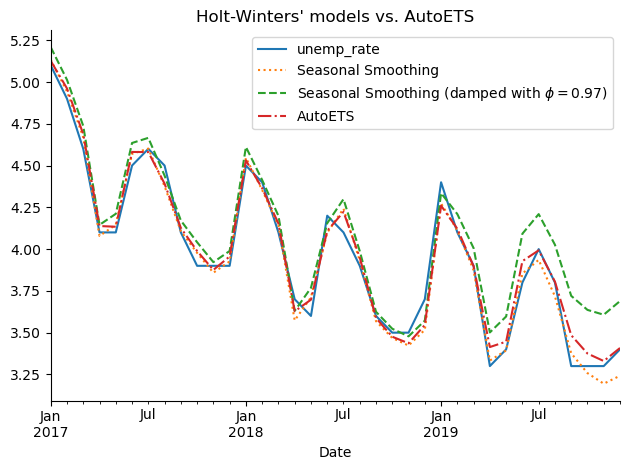

In [117]:
auto_ets_df = hw_df.to_period().copy()
auto_ets_df["auto_ets"] = (
    auto_ets
    ._fitted_forecaster
    .fittedvalues
    .append(auto_ets_fcst["Value"])
)

fig, ax = plt.subplots()
auto_ets_df["2017":].plot(
    style=["-",":","--","-."], ax=ax,
    title="Holt-Winters' models vs. AutoETS"
)
labels = [
    "unemp_rate", 
    "Seasonal Smoothing",
    f"Seasonal Smoothing (damped with $\phi={phi:.2f}$)",
    "AutoETS",
]
ax.legend(labels)

sns.despine()
plt.tight_layout()

### 4. Calculate the MAPEs of the Holt-Winters' forecast and of AutoETS

In [118]:
fcst_dict = {
    "Seasonal Smoothing": hw_forecast_1,
    "Seasonal Smoothing (damped)": hw_forecast_2,
    "AutoETS": auto_ets_fcst
}

print("MAPEs ----")
for key, value in fcst_dict.items():
    mape = mean_absolute_percentage_error(df_test, value)
    print(f"{key}: {100 * mape:.2f}%" )

MAPEs ----
Seasonal Smoothing: 1.81%
Seasonal Smoothing (damped): 6.53%
AutoETS: 1.78%


# Modeling time series with ARIMA class models